In [193]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

%matplotlib inline

## Load the Data

In [194]:
df = pd.read_csv("data.csv")

In [195]:
df.shape

(9529, 19)

In [196]:
df.head(2)

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median
0,1,Manchester United,Jack Butland,Goalkeeper,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper,1304.0
1,2,Manchester United,Tom Heaton,Goalkeeper,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper,292.0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [197]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median


In [198]:
# Completeness
df.isnull().sum()

Id                       0
team                     0
name                     0
position                 0
age                      0
appearance               0
goals                    0
assists                  0
goals conceded           0
clean sheets             0
minutes played           0
days_injured             0
games_injured            0
award                    0
current_value            0
highest_value            0
position_encoded         0
position_grouped         0
minutes_played_median    0
dtype: int64

In [199]:
# Accurecy types
df.dtypes

Id                         int64
team                      object
name                      object
position                  object
age                      float64
appearance                 int64
goals                    float64
assists                  float64
goals conceded           float64
clean sheets             float64
minutes played             int64
days_injured               int64
games_injured              int64
award                      int64
current_value              int64
highest_value              int64
position_encoded           int64
position_grouped          object
minutes_played_median    float64
dtype: object

In [200]:
df.drop("position", axis=1, inplace=True)
df.drop("name", axis=1, inplace=True)

In [201]:
df.head(2)

,Id,team,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median
0,1,Manchester United,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper,1304.0
1,2,Manchester United,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper,292.0


In [202]:

# Convert categorical variables using OneHotEncoding
categorical_features = ['team']
numeric_features = ['minutes_played_median', 'position_grouped', 'position_encoded','highest_value','current_value','award','games_injured','days_injured','minutes played','clean sheets','goals conceded','assists','goals','appearance','age']

In [203]:
for i in categorical_features:
    print (df[i].value_counts())

team
FC Seoul           42
Daegu FC           41
Royal AM FC        40
Gangwon FC         40
Swallows FC        39
                   ..
Gaziantep FK        5
Manchester City     5
Real Madrid         5
FC Barcelona        5
Bayern Munich       4
Name: count, Length: 374, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [204]:
df.head(2)

,Id,team,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median
0,1,Manchester United,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper,1304.0
1,2,Manchester United,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper,292.0


In [205]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [206]:
df.shape

(9529, 390)

In [207]:
# Calculate the 35th and 75th percentiles of the price
p20 = df['current_value'].quantile(0.20)
p50 = df['current_value'].quantile(0.50)

# Function to categorize prices
def categorize_price(current_value):
    if current_value < p20:
        return 'Average Player'
    elif current_value < p50:
        return 'Good Player'
    else:
        return 'Professional Player'

# Apply the function to create a new column
df['player_leval_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['player_leval_category'].value_counts())

player_leval_category
Professional Player    5006
Good Player            2862
Average Player         1661
Name: count, dtype: int64


In [208]:
p20 , p50

(200000.0, 700000.0)

In [209]:
encoder = LabelEncoder()
df['player_leval_category_encoded'] = encoder.fit_transform(df['player_leval_category']) 

#### 3. Feature selection

In [210]:
correlation = df.corr(numeric_only=True)
print(correlation['player_leval_category_encoded'].sort_values(ascending=False))

player_leval_category_encoded    1.000000
appearance                       0.497586
minutes played                   0.468589
minutes_played_median            0.421660
highest_value                    0.394990
                                   ...   
team_Al-Batin FC                -0.088095
team_Marumo Gallants FC         -0.088875
team_Royal AM FC                -0.096294
goals conceded                  -0.128908
Id                              -0.480537
Name: player_leval_category_encoded, Length: 389, dtype: float64


In [211]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['player_leval_category_encoded']) > \
threshold]['player_leval_category_encoded'].index
selected_features

Index(['Id', 'appearance', 'goals', 'assists', 'minutes played',
       'days_injured', 'games_injured', 'award', 'highest_value',
       'minutes_played_median', 'player_leval_category_encoded'],
      dtype='object')

In [212]:
selected_features = ['appearance', 'minutes played', 'days_injured', 'games_injured',
       'award', 'highest_value', 'player_leval_category_encoded']
     

In [213]:
df = df[selected_features]
df.head()

,appearance,minutes played,days_injured,games_injured,award,highest_value,player_leval_category_encoded
0,15,1304,510,58,1,22000000,2
1,4,292,697,84,4,6000000,1
2,68,4762,148,27,1,70000000,2
3,70,5471,95,19,10,35000000,2
4,34,2758,47,13,0,2000000,2


#### 4. Prepare train and test data

In [214]:
# Prepare data
X = df.drop(['player_leval_category_encoded'], axis=1)
y = df['player_leval_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Buliding the Model

In [215]:
model = LogisticRegression()

### Train the Model

In [216]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

## Test the Model

In [217]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [218]:
# Each row of the model.coef_ matrix tells you how each feature affects being in the corresponding class versus any other class
coeff_df = pd.DataFrame(model.coef_[2],X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,0.426157
minutes played,0.184159
days_injured,0.034902
games_injured,-0.043506
award,-0.065806
highest_value,5.534401


In [219]:
model.coef_

array([[-0.73879192, -0.01417443, -0.04494733, -0.1561106 , -0.0147432 ,
        -6.166796  ],
       [ 0.31263497, -0.16998414,  0.01004544,  0.19961664,  0.08054961,
         0.63239529],
       [ 0.42615695,  0.18415857,  0.03490189, -0.04350603, -0.06580641,
         5.53440072]])

In [220]:
print(model.intercept_) 

[-3.55822741  0.88351378  2.67471363]


## Evaluating the Model

In [221]:
print(df.columns)


Index(['appearance', 'minutes played', 'days_injured', 'games_injured',
       'award', 'highest_value', 'player_leval_category_encoded'],
      dtype='object')


In [222]:
# our benchmark model
base_model = round(df['player_leval_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

30.03

1. Accuracy

In [223]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7345225603357818

In [224]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.7422274695001968

2. Confusion Matrix

In [225]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[210,  93,  10],
       [111, 329, 123],
       [ 14, 155, 861]])

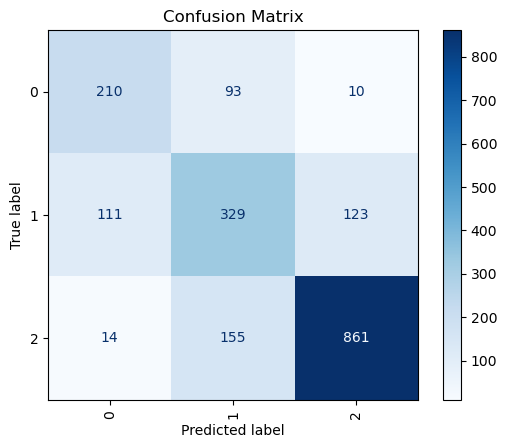

In [226]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

3. Precision

In [227]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.69


4. Recall

In [228]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.70


5. F1 Score

In [229]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.69
